In [1]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [3]:
#workingpath = "/content/drive/MyDrive/Colab Notebooks/project/" 

#Data loading section

In [4]:
df=pd.read_csv("KaggleV2_May_2016.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679510e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841190e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


# data clean up

##check duplicate and na

In [5]:
df.duplicated().any()

False

In [6]:
df.isnull().values.any()


False

In [7]:
df[df.Age==-1].shape[0]

1

In [8]:
df['Handcap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [9]:
df = df[df.Age >= 0]

In [10]:
df.shape

(110526, 14)

##remove patient&appointment ID


In [11]:
df.drop(['PatientId','AppointmentID'],axis=1,inplace=True)


In [12]:
df.AppointmentDay=pd.to_datetime(df.AppointmentDay)
df.ScheduledDay=pd.to_datetime(df.ScheduledDay)
df['daystoappoint']=(df.AppointmentDay-df.ScheduledDay).dt.days+1
df.drop(['ScheduledDay','AppointmentDay'],axis=1,inplace=True)


## make dummy variables

### gender

In [13]:
le=LabelEncoder()
df['Gender']=le.fit_transform(df['Gender']) # 0 is famale 1 is male

###Neighbourhood

In [14]:
n = len(pd.unique(df['Neighbourhood']))
n

81

In [15]:
#dummy=pd.get_dummies(df.Neighbourhood, prefix='NB')
#df=df.merge(dummy, how='outer', left_index=True, right_index=True)
df.drop(['Neighbourhood'],axis=1,inplace=True)


In [16]:
dummy=pd.get_dummies(df.Handcap, prefix='Hcap')
df=df.merge(dummy, how='outer', left_index=True, right_index=True)
df.drop(['Handcap'],axis=1,inplace=True)


### dependent variable No_show to 0 or 1

In [17]:
df['No-show'] = le.fit_transform(df['No-show'])# 0=no 1=yes
df.head(10)

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No-show,daystoappoint,Hcap_0,Hcap_1,Hcap_2,Hcap_3,Hcap_4
0,0,62,0,1,0,0,0,0,0,1,0,0,0,0
1,1,56,0,0,0,0,0,0,0,1,0,0,0,0
2,0,62,0,0,0,0,0,0,0,1,0,0,0,0
3,0,8,0,0,0,0,0,0,0,1,0,0,0,0
4,0,56,0,1,1,0,0,0,0,1,0,0,0,0
5,0,76,0,1,0,0,0,0,2,1,0,0,0,0
6,0,23,0,0,0,0,0,1,2,1,0,0,0,0
7,0,39,0,0,0,0,0,1,2,1,0,0,0,0
8,0,21,0,0,0,0,0,0,0,1,0,0,0,0
9,0,19,0,0,0,0,0,0,2,1,0,0,0,0


## Organize dataframe

### put the dependent variable to the front

In [18]:
col_name = "No-show"
first_col = df.pop(col_name)
df.insert(0, col_name, first_col)
df.head()

,No-show,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,daystoappoint,Hcap_0,Hcap_1,Hcap_2,Hcap_3,Hcap_4
0,0,0,62,0,1,0,0,0,0,1,0,0,0,0
1,0,1,56,0,0,0,0,0,0,1,0,0,0,0
2,0,0,62,0,0,0,0,0,0,1,0,0,0,0
3,0,0,8,0,0,0,0,0,0,1,0,0,0,0
4,0,0,56,0,1,1,0,0,0,1,0,0,0,0


### Plot age to no-show

In [19]:
age_show = df[['No-show','Age']]
dummy=pd.get_dummies(age_show['No-show'], prefix='Noshow')
age_show=age_show.merge(dummy, how='outer', left_index=True, right_index=True)
age_show.drop(['No-show'],axis=1,inplace=True)

#plt.plot( df['No-show'],df['Age'],'.',  color='black');

In [36]:

group_age_show=age_show.groupby(pd.cut(age_show['Age'], np.arange(0, 120, 10))).sum()
group_age_show['show%']=100*group_age_show['Noshow_0']/(group_age_show['Noshow_0']+group_age_show['Noshow_1'])
group_age_show['noshow%']=100*group_age_show['Noshow_1']/(group_age_show['Noshow_0']+group_age_show['Noshow_1'])
group_age_show

,Age,Noshow_0,Noshow_1,show%,noshow%
Age,,,,,
"(0, 10]",78284,12061.0,3149.0,79.296515,20.703485
"(10, 20]",207351,9791.0,3308.0,74.746164,25.253836
"(20, 30]",352297,10389.0,3394.0,75.375463,24.624537
"(30, 40]",534662,11820.0,3232.0,78.527770,21.472230
"(40, 50]",658643,11550.0,2870.0,80.097087,19.902913
"(50, 60]",867816,12940.0,2721.0,82.625631,17.374369
"(60, 70]",727015,9541.0,1648.0,85.271249,14.728751
"(70, 80]",429761,4832.0,889.0,84.460759,15.539241
"(80, 90]",214700,2137.0,407.0,84.001572,15.998428


In [37]:
del group_age_show['Age']


In [38]:
group_age_show.reset_index(inplace=True)
group_age_show


,Age,Noshow_0,Noshow_1,show%,noshow%
0,"(0, 10]",12061.0,3149.0,79.296515,20.703485
1,"(10, 20]",9791.0,3308.0,74.746164,25.253836
2,"(20, 30]",10389.0,3394.0,75.375463,24.624537
3,"(30, 40]",11820.0,3232.0,78.527770,21.472230
4,"(40, 50]",11550.0,2870.0,80.097087,19.902913
5,"(50, 60]",12940.0,2721.0,82.625631,17.374369
6,"(60, 70]",9541.0,1648.0,85.271249,14.728751
7,"(70, 80]",4832.0,889.0,84.460759,15.539241
8,"(80, 90]",2137.0,407.0,84.001572,15.998428
9,"(90, 100]",242.0,59.0,80.398671,19.601329


In [39]:
group_age_show.dtypes
group_age_show['Age']=group_age_show['Age'].astype(str)

People in younger age group has higher'No show' rate than older age group


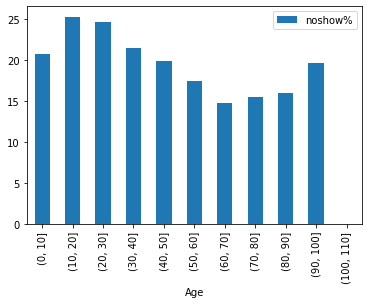

In [42]:
group_age_show.plot(kind ='bar',
                    x='Age',
                    y = 'noshow%')
print("People in younger age group has higher'No show' rate than older age group")

### Plot days_to_appiont to no-show

In [46]:
max(df['daystoappoint'])


179

In [48]:
days_show = df[['No-show','daystoappoint']]
dummy=pd.get_dummies(days_show['No-show'], prefix='Noshow')
days_show=days_show.merge(dummy, how='outer', left_index=True, right_index=True)
days_show.drop(['No-show'],axis=1,inplace=True)


In [96]:
group_days_show=days_show.groupby(pd.cut(days_show['daystoappoint'], np.arange(0, 150,15))).sum()
group_days_show['show%']=100*group_days_show['Noshow_0']/(group_days_show['Noshow_0']+group_days_show['Noshow_1'])
group_days_show['noshow%']=100*group_days_show['Noshow_1']/(group_days_show['Noshow_0']+group_days_show['Noshow_1'])


In [97]:
del group_days_show['daystoappoint']

In [98]:
group_days_show.reset_index(inplace=True)


In [99]:
group_days_show['daystoappoint']=group_days_show['daystoappoint'].astype(str)
group_days_show

,daystoappoint,Noshow_0,Noshow_1,show%,noshow%
0,"(0, 15]",33775.0,11938.0,73.884891,26.115109
1,"(15, 30]",10709.0,5159.0,67.488026,32.511974
2,"(30, 45]",4264.0,2241.0,65.549577,34.450423
3,"(45, 60]",1190.0,588.0,66.929134,33.070866
4,"(60, 75]",1048.0,415.0,71.633630,28.366370
5,"(75, 90]",290.0,125.0,69.879518,30.120482
6,"(90, 105]",76.0,25.0,75.247525,24.752475
7,"(105, 120]",29.0,2.0,93.548387,6.451613
8,"(120, 135]",13.0,6.0,68.421053,31.578947


the days to appointment longer than half month has a higher 'no-show' rate
For appointments over than 3 months, there is an decrease of 'no-show' rate, may need to check if they are chornic deseases


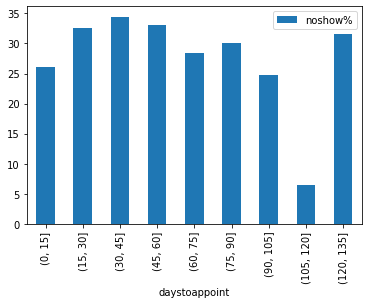

In [101]:
group_days_show.plot(kind ='bar',
                     x='daystoappoint',
                    y = 'noshow%')
print("the days to appointment longer than half month has a higher 'no-show' rate")
print("For appointments over than 3 months, there is an decrease of 'no-show' rate, may need to check if they are chornic deseases")


In [91]:

#profile = ProfileReport( df, title='Pandas profiling report' , html={'style':{'full_width':True}})

#profile.to_notebook_iframe()

### split data into training set(80%) and testing set(20%)


In [20]:

X = df.drop(['No-show'],axis = 1)
y = df['No-show']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=42)
# Returning to one dataframe
training_set = pd.concat([Xtrain, ytrain], axis=1)
training_set = training_set.rename(columns = {'No-show': 'Noshow'})
training_set.head()


,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,daystoappoint,Hcap_0,Hcap_1,Hcap_2,Hcap_3,Hcap_4,Noshow
58187,0,25,0,0,0,0,0,8,1,0,0,0,0,0
5095,1,62,0,0,0,0,0,4,1,0,0,0,0,0
67919,0,65,0,0,0,0,0,48,1,0,0,0,0,1
2861,1,41,0,0,0,0,0,0,1,0,0,0,0,0
45949,1,61,0,1,0,1,0,3,1,0,0,0,0,0


# Modeling

In [21]:
# Separating classes
show = training_set[training_set.Noshow == 0]
not_show = training_set[training_set.Noshow == 1]
len(show)

70492

In [22]:
# Undersampling the majority
undersample = resample(show, 
                       replace=True, 
                       n_samples=len(not_show), #set the number of samples to equal the number of the minority class
                       random_state=42)
# Returning to new training set
undersample_train = pd.concat([not_show, undersample])
undersample_train.Noshow.value_counts(normalize=True)

1    0.5
0    0.5
Name: Noshow, dtype: float64

In [23]:
# Separate oversampled data into X and y sets
undersample_X_train = undersample_train.drop('Noshow', axis=1)
undersample_y_train = undersample_train.Noshow

## Decision Tree


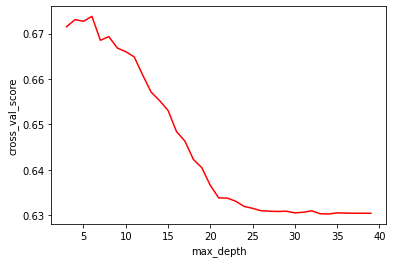

best depth: 6


In [24]:
#5-fold Cross-validation to set the depth
depth=[]
for i in range(3,40):
  clf = DecisionTreeClassifier(max_depth=i,random_state=42)
  CVscore=np.mean(cross_val_score(clf, undersample_X_train, undersample_y_train, cv=3))
  depth.append(CVscore)
plt.figure()
line1, = plt.plot(list(range(3, 40)), depth, color="r", label="depth")
plt.ylabel('cross_val_score')
plt.xlabel('max_depth')

plt.show()
print("best depth:",3+depth.index(max(depth)))

[Text(1286.015625, 1892.892857142857, 'X[7] <= 0.5\ngini = 0.5\nsamples = 35856\nvalue = [17928, 17928]'),
 Text(595.78125, 1601.6785714285716, 'X[1] <= 25.5\ngini = 0.266\nsamples = 9001\nvalue = [7578, 1423]'),
 Text(305.15625, 1310.4642857142858, 'X[1] <= 6.5\ngini = 0.33\nsamples = 3760\nvalue = [2977, 783]'),
 Text(145.3125, 1019.25, 'X[9] <= 0.5\ngini = 0.19\nsamples = 1330\nvalue = [1189, 141]'),
 Text(116.25, 728.0357142857142, 'X[1] <= 3.5\ngini = 0.188\nsamples = 1329\nvalue = [1189, 140]'),
 Text(58.125, 436.82142857142844, 'X[1] <= 0.5\ngini = 0.174\nsamples = 965\nvalue = [872, 93]'),
 Text(29.0625, 145.6071428571429, 'gini = 0.218\nsamples = 313\nvalue = [274, 39]'),
 Text(87.1875, 145.6071428571429, 'gini = 0.152\nsamples = 652\nvalue = [598, 54]'),
 Text(174.375, 436.82142857142844, 'X[1] <= 5.5\ngini = 0.225\nsamples = 364\nvalue = [317, 47]'),
 Text(145.3125, 145.6071428571429, 'gini = 0.254\nsamples = 214\nvalue = [182, 32]'),
 Text(203.4375, 145.6071428571429, 'gini

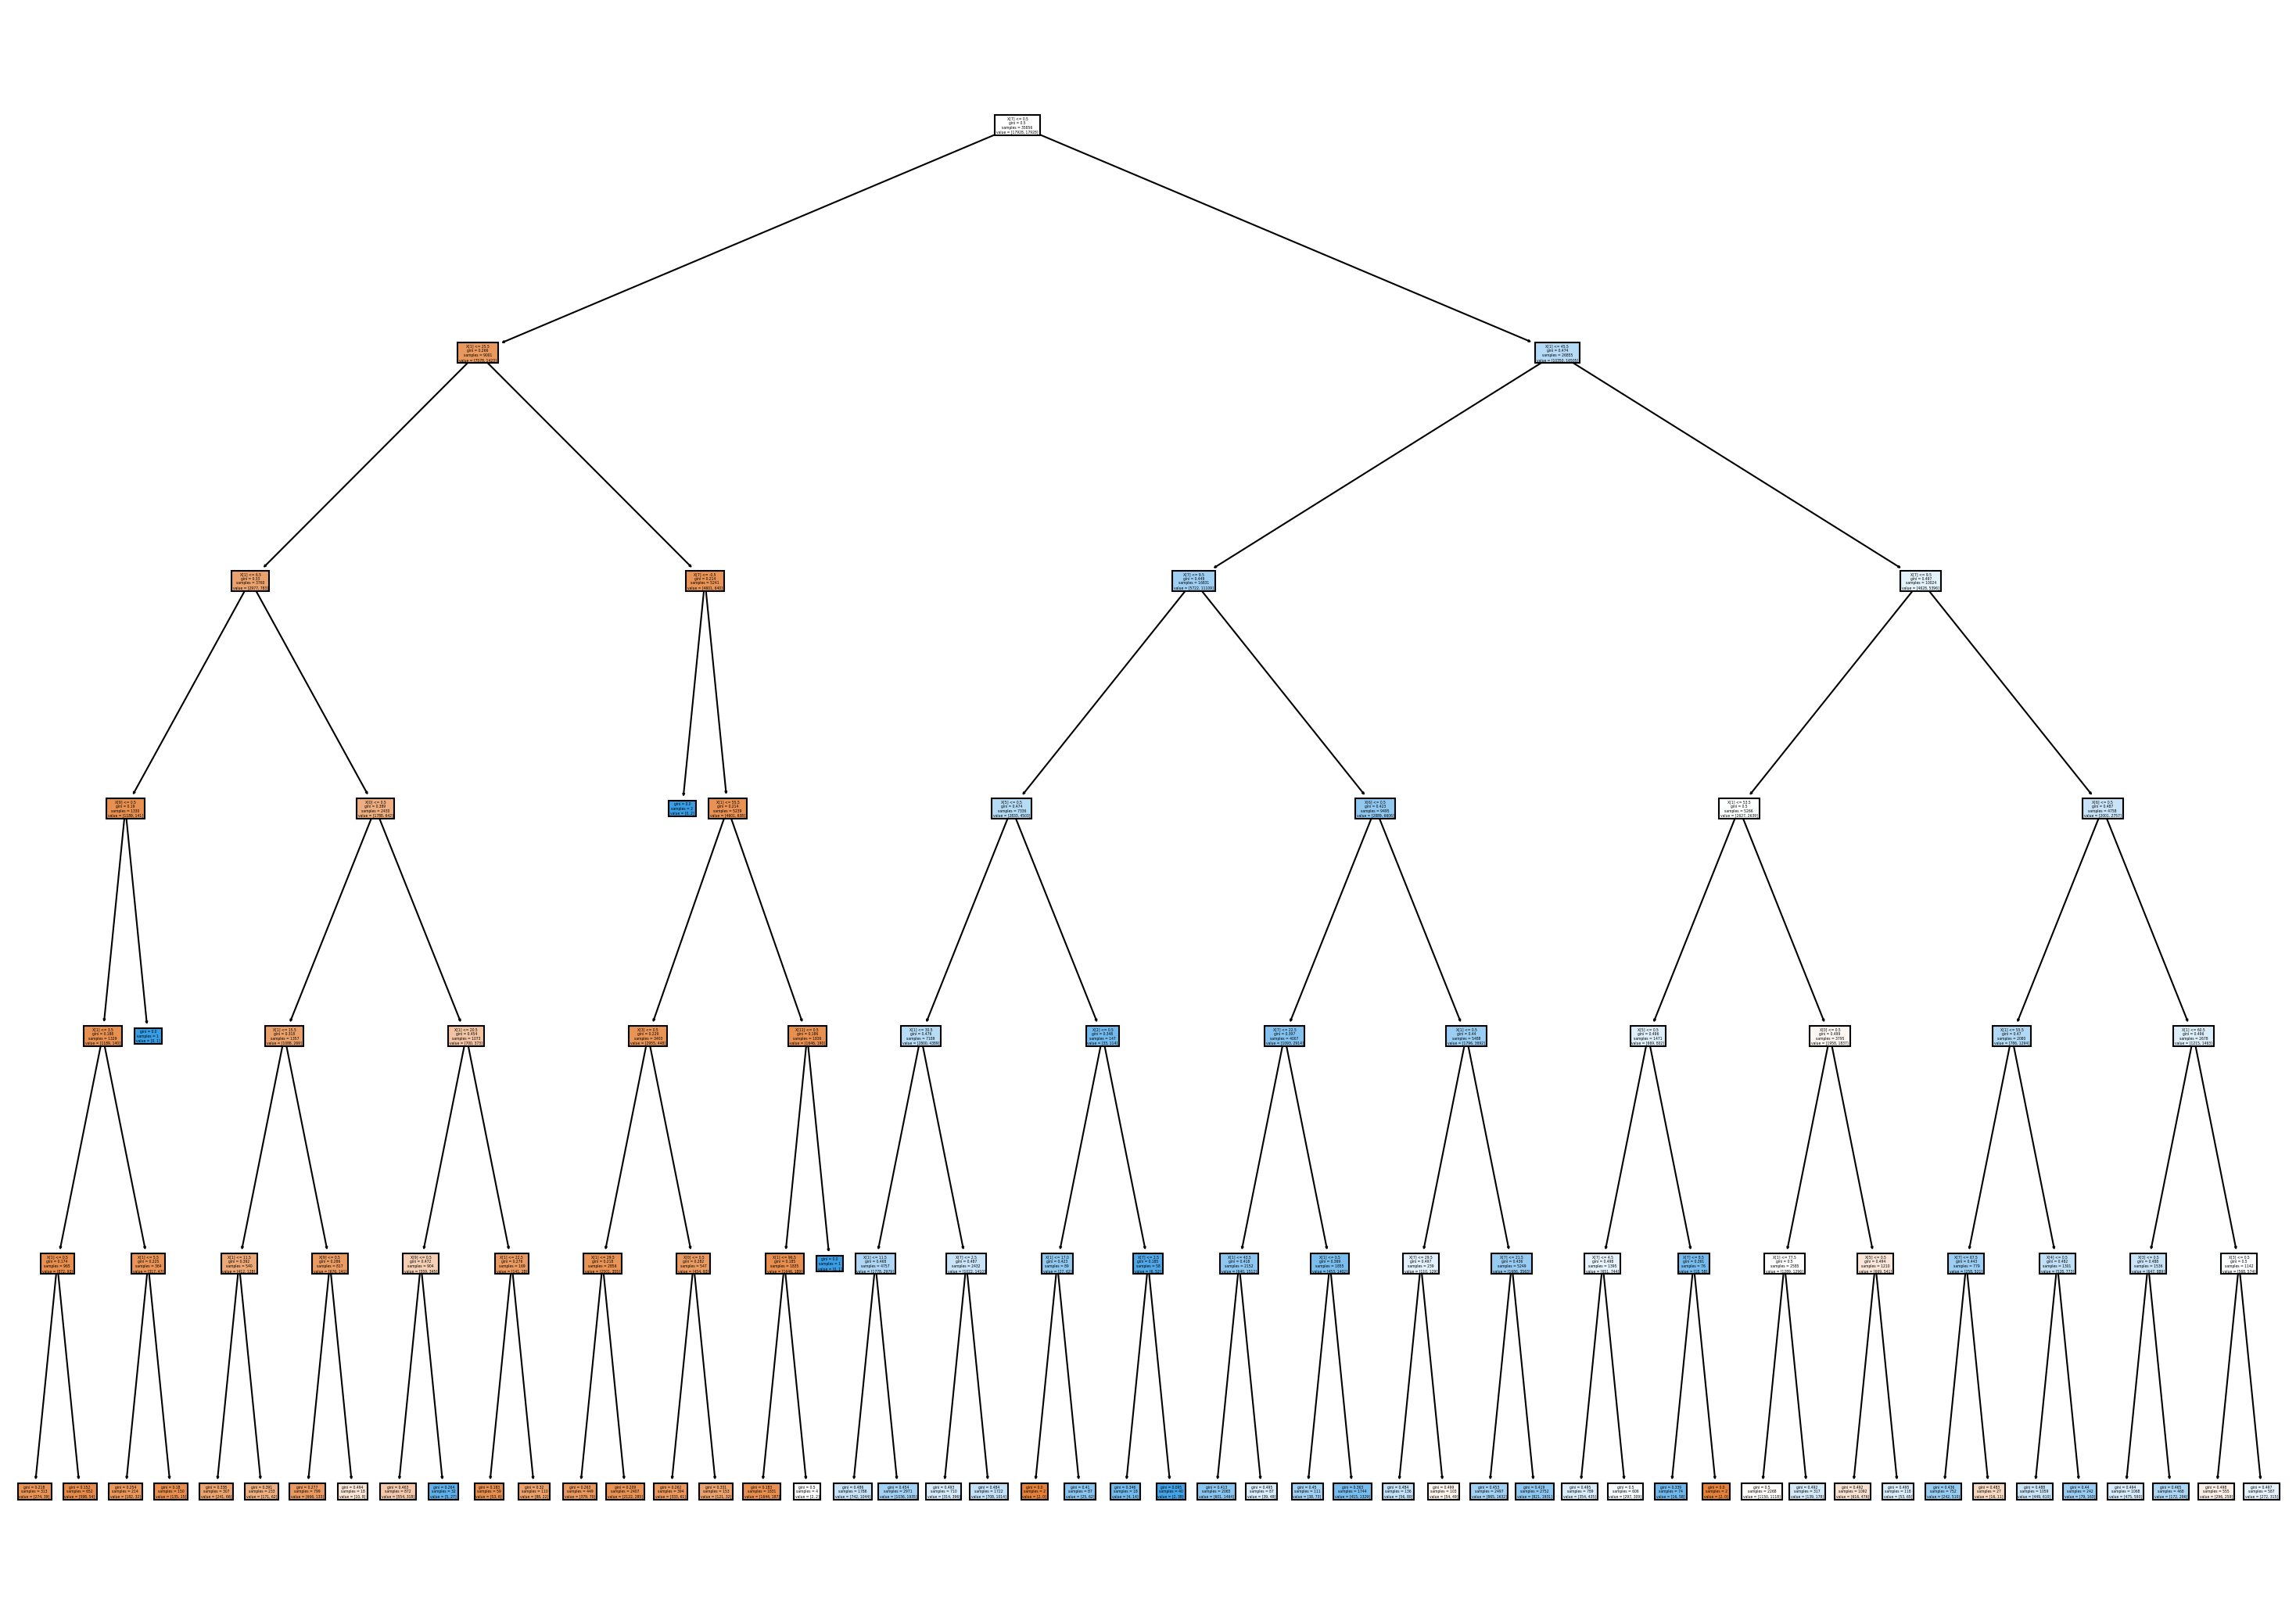

In [25]:
plt.figure( figsize=[25,18],dpi=150)
Dtree = DecisionTreeClassifier(max_depth=6,random_state=42).fit(undersample_X_train, undersample_y_train)
plot_tree(Dtree,filled=True)

In [26]:
y_pred_Dtree=Dtree.predict(Xtest)
tree_accuracy=accuracy_score(ytest, y_pred_Dtree)
tree_accuracy

0.5856780964444043

In [27]:
tn, fp, fn, tp = confusion_matrix(ytest, y_pred_Dtree).ravel()
specificity = tn / (tn+fp)
specificity

0.5294383290996331

In [28]:
sensitivity = tp/(tp+fn)
sensitivity

0.812571168298793

## Random forest

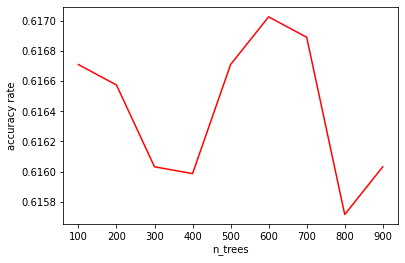

In [29]:
tree_list=[]
test_results = []
list_nb_trees = np.arange(100, 1000, 100).tolist()

for nb_trees in list_nb_trees:
    rf = RandomForestClassifier(n_estimators=nb_trees,random_state=42)
    y_pre_RF=rf.fit(undersample_X_train, undersample_y_train).predict(Xtest)
    test_results.append(accuracy_score(ytest, y_pre_RF))
    

line1, = plt.plot(list_nb_trees, test_results, color="r", label="Randomforest")


plt.ylabel('accuracy rate')
plt.xlabel('n_trees')
plt.show()

In [30]:
best_ntrees=list_nb_trees[test_results.index(max(test_results))]
best_ntrees

600

In [44]:
RF = RandomForestClassifier(n_estimators=600,random_state=42).fit(undersample_X_train, undersample_y_train)




In [45]:
y_pred_RF=RF.predict(Xtest)
RF_accuracy=accuracy_score(ytest, y_pred_RF)
RF_accuracy

0.6170270514792364

In [46]:
tn, fp, fn, tp = confusion_matrix(ytest, y_pred_RF).ravel()
specificity = tn / (tn+fp)
specificity

0.6060400790290714

In [47]:
sensitivity = tp/(tp+fn)
sensitivity

0.661352767023457

13
Feature ranking:
1. feature daystoappoint (0.530353)
2. feature Age (0.404918)
3. feature SMS_received (0.022762)
4. feature Gender (0.012427)
5. feature Hipertension (0.007109)
6. feature Scholarship (0.006636)
7. feature Diabetes (0.005797)
8. feature Alcoholism (0.005239)
9. feature Hcap_0 (0.002031)
10. feature Hcap_1 (0.001926)


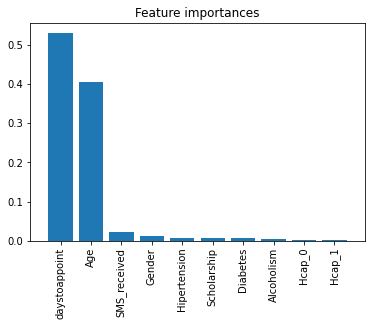

In [49]:
df_Col=list(Xtrain.columns)
importances=RF.feature_importances_
print(len(importances))
std = np.std([tree.feature_importances_ for tree in RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
top10 = []
for f in range(10):
  top=df_Col[indices[f]]
  print("%d. feature %s (%f)" % (f + 1, top, importances[indices[f]]))
  top10.append(top)


# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar([x for x in range(10)], importances[indices[0:10]])
plt.xticks(range(10),top10,rotation=90)
plt.xlim([-1, 10])
plt.show()


## adaboost

In [60]:
#CV
ada_list=[]

list_nb = np.arange(5, 50, 2).tolist()

for nb in list_nb:
    rf = RandomForestClassifier(n_estimators=nb,random_state=42)
    y_pre_RF=rf.fit(undersample_X_train, undersample_y_train).predict(Xtest)
    ada_list.append(accuracy_score(ytest, y_pre_RF))
    



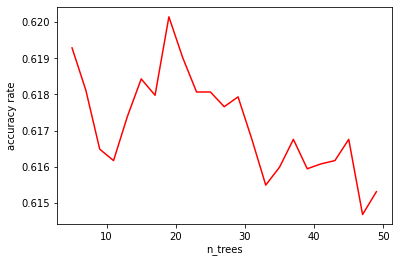

best estimators: 19


In [64]:
line1, = plt.plot(list_nb, ada_list, color="r", label="Randomforest")


plt.ylabel('accuracy rate')
plt.xlabel('n_trees')
plt.show()

print("best estimators:",5+2*(ada_list.index(max(ada_list))))

In [65]:
ada = AdaBoostClassifier(n_estimators=19, random_state=42).fit(undersample_X_train, undersample_y_train)

In [66]:
y_pred_ada=ada.predict(Xtest)
ada_accuracy=accuracy_score(ytest, y_pred_ada)
ada_accuracy

0.5653216321360717

In [67]:
tn, fp, fn, tp = confusion_matrix(ytest, y_pred_ada).ravel()
specificity = tn / (tn+fp)
specificity

0.4960203217612193

In [68]:
sensitivity = tp/(tp+fn)
sensitivity

0.8449100432703257